In [25]:
import math

import torch
from torch import tensor
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf

from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error
import sklearn.datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from plot import plot_prediction
import numpy as np

%matplotlib inline

from plot import *

In [26]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Optimizing Test Functions with EIpS

In [27]:
torch.manual_seed(0)

# BO design points
x_ = torch.arange(-1., 1.0, 0.01)
y_ = torch.arange(-1., 1.0, 0.01)
x_axis, y_axis = torch.meshgrid(x_, y_)
grid = torch.rot90(torch.stack((x_axis, y_axis), 2))

X_ = grid.reshape(len(x_)*len(y_), 2)

## Ridge Regression

In [28]:
#dataset = ds.load_iris()
dataset = ds.load_digits(n_class=2)
X = dataset.data
y = dataset.target

#X = X[y > 0]
#y = y[y > 0]
#y -= 1
scaler = StandardScaler()
X = scaler.fit_transform(X)

# test train split
#X, y = ds.make_moons(200, noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# hyperparameter search space
gamma_min = -9.
gamma_max = 3 #3
llambda_min = -2
llambda_max = 10 #10
resolution = 13
gamma_space = (np.logspace(gamma_min, gamma_max, resolution, base=2))
llambda_space = (np.logspace(llambda_min, llambda_max, resolution, base=2))

def log_scale(x, min, max): # map from [-1, 1] to log2([min, max])
    return torch.exp2((max - min) * ((x+1)*0.5) + min)

def plot_KRR_space_test(scores, X_samples, gamma_space, llambda_space):
    gamma_scaled = log_scale(X_samples[:, 0], gamma_min, gamma_max)
    llambda_scaled = log_scale(X_samples[:, 1], llambda_min, llambda_max)

    p, ax = plt.subplots(figsize=(8, 6))
    ax.title.set_text("Validation accuracy")

    im=ax.imshow(
        np.rot90(scores),
        interpolation="nearest",
        cmap=plt.cm.hot,
        extent=[0, len(gamma_space), 0, len(llambda_space)]
    )
    plt.colorbar(im)

    ax.set_xticks(np.arange(len(gamma_space)))
    ax.set_xticklabels(gamma_space, rotation=45)
    ax.set_yticks(np.arange(len(llambda_space)))
    ax.set_yticklabels(llambda_space)

    plt.show()
    plt.figure(figsize=(8, 8))
    plt.scatter(gamma_scaled, llambda_scaled, c='green')
    plt.xlabel("gamma")
    plt.ylabel("lambda")
    plt.xscale('log', base=2)
    plt.xscale('log', base=2)
    plt.title("Sample Locations")
    plt.show()

def sample_regression(gamma, llambda, K=None, scale=True):
    if scale:
        gamma = log_scale(gamma, gamma_min, gamma_max)
        llambda = log_scale(llambda, llambda_min, llambda_max)

    gamma = float(gamma)
    llambda = float(llambda)
    # train
    kr = KernelRidge(alpha=llambda, gamma=gamma, kernel='precomputed')
    kernel = RBF(length_scale=gamma)
    if K is None:
        K = kernel.__call__(X_train)
    kr.fit(K, y_train)

    # test
    K_xX = kernel.__call__(X_test, Y=X_train)
    predictions = kr.predict(K_xX)
    score = mean_squared_error(y_test, predictions)

    return tensor(score), K

In [29]:
scores = torch.zeros((len(gamma_space), len(llambda_space)))
best_score = math.inf
best_candidate = [0, 0]
for ix, x_ax in enumerate(gamma_space):  # gamma
    for iy, y_ax in enumerate(llambda_space):  # llambda
        scores[ix][iy] = sample_regression(torch.tensor(x_ax),
                                           torch.tensor(y_ax),
                                           scale=False)[0]

        if scores[ix][iy] < best_score:
            best_score = scores[ix][iy]
            best_candidate = [x_ax, y_ax]

## Bayesian Optimization

kernel strategy:  replace_worst
::::::::::::::::::::::::::::::::::::::::::::::::::::
Sample  0
initialization
candidate:  tensor([0.4963, 0.7682])
model score for candidate:  0.4349862763600734
iteration:       0
stored candidates:  0
sampling candidate:  tensor([[-0.9512, -0.8711]])
score:  tensor(0.4352, dtype=torch.float64)
iteration:       1.0
stored candidates:  1
sampling candidate:  tensor([[-0.9512,  0.9000]])
score:  tensor(0.4352, dtype=torch.float64)
iteration:       1.5
stored candidates:  2
sampling candidate:  tensor([[-0.9512,  0.0124]])
score:  tensor(0.4352, dtype=torch.float64)
iteration:       2.0
stored candidates:  3
sampling candidate:  tensor([[ 0.9900, -1.0000]])
score:  tensor(0.0153, dtype=torch.float64)
Replaced Kernel!
iteration:       3.0
stored candidates:  3
sampling candidate:  tensor([[ 0.9900, -0.8108]])
score:  tensor(0.0174, dtype=torch.float64)
iteration:       3.5
stored candidates:  3
sampling candidate:  tensor([[ 0.6590, -1.0000]])
score:  tenso

[]

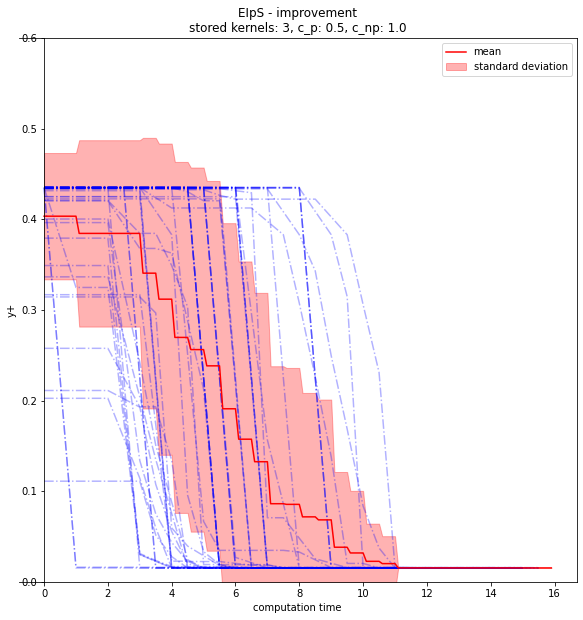

In [30]:
y_samples_all = []
all_best = []
def sample_bo(n_iters:int, compute_time_iter:bool, c_p=1, c_np=1, max_stored_kernels=3, kernel_strategy='replace_worst', plot=False):
    bounds = tensor([[x_[0], y_[0]], [x_[-1], y_[-1]]])

    X_samples = tensor([[torch.rand((1)), torch.rand((1))]])
    y_samples = sample_regression(X_samples[:,0], X_samples[:,1])[0].reshape(-1, 1)
    print("=======================")
    print("initialization")
    print("candidate: ", X_samples[0])
    print("model score for candidate: ", float(y_samples[0]))

    # EIpS stuff
    kernel_matrices = []
    kernel_parameters = []
    kernel_evaluations = []
    total_compute_time = 0
    compute_time_steps = tensor([[0]])
    current_iter = 0
    while current_iter < n_iters:
        print("=======================")
        print("iteration:      ", current_iter)
        print("stored candidates: ", len(kernel_parameters))
        compute_time = c_np
        gp = SingleTaskGP(X_samples, y_samples)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_model(mll)

        EI = acqf.ExpectedImprovement(
            gp,
            y_samples.min(),
            maximize=False
        )
        best_candidate, acq_value = optimize_acqf(
            acq_function=EI,
            bounds=bounds,
            q=1,
            num_restarts=1,
            raw_samples=20
        )

        # calculate EIpS for new candidate proposal
        acq_value = acq_value/c_np

        # EIpS step
        best_candidate_ix = -1
        for ix, candidate_stored in enumerate(kernel_parameters):
            # Calculate EIpS for stored candidates
            bounds_candidate_stored = tensor([[candidate_stored[0], y_[0]],
                                              [candidate_stored[0], y_[-1]]])
            new_candidate_stored, acq_value_stored = optimize_acqf(
                acq_function=EI,
                bounds=bounds_candidate_stored,
                q=1,
                num_restarts=1,
                raw_samples=20
            )
            # calculate EIpS value of new candidate with stored kernel
            acq_value_stored = acq_value_stored/c_p

            # compare EIpS values against each other, pick the higher one
            if acq_value < acq_value_stored:
                acq_value = acq_value_stored
                best_candidate = new_candidate_stored
                best_candidate_ix = ix # kernel matrix index of best candidate
                compute_time = c_p

        # add chosen candidate to sample list, score model
        K = None
        if best_candidate_ix != -1:
            K = kernel_matrices[best_candidate_ix]
        print("sampling candidate: ", best_candidate)
        y_new_sample, K = sample_regression(best_candidate[0][0],
                                            best_candidate[0][1],
                                            K)
        print("score: ", y_new_sample)
        # plot
        if plot:
            plot_bo_KRR(gp, EI, X_samples)

        X_samples = torch.vstack((X_samples, best_candidate))
        y_samples = torch.vstack((y_samples, y_new_sample))

        total_compute_time += compute_time
        compute_time_steps = torch.vstack((compute_time_steps, tensor([total_compute_time])))

        # store new kernel matrix
        if len(kernel_parameters) < max_stored_kernels:
            #print("Added kernel matrix at iter ", i)
            kernel_evaluations.append(y_new_sample)     # model score
            kernel_parameters.append(best_candidate[0])    # scored model parameters
            kernel_matrices.append(K)
        elif kernel_strategy == "replace_worst":
            #print("replacing worst")
            val = min(kernel_evaluations) # smaller model score is better
            ix = kernel_evaluations.index(val)
            if val > y_new_sample: # if new model score better (smaller) than old, replace
                kernel_evaluations[ix] = y_new_sample   # model score
                kernel_parameters[ix] = best_candidate[0]  # scored model parameters
                kernel_matrices[ix] = K
                print("Replaced Kernel!")
        elif kernel_strategy == "replace_oldest":
            #print("replacing oldest")
            kernel_evaluations.pop(0)
            kernel_parameters.pop(0)
            kernel_matrices.pop(0)
            kernel_evaluations.append(y_new_sample)     # model score
            kernel_parameters.append(best_candidate[0])    # scored model parameters
            kernel_matrices.append(K)                       # kernel matrix
            print("Replaced Kernel!")

        # increase iteration count by one if using limited iterations,
        # set to total compute time if using limited compute time
        if compute_time_iter:
            current_iter = total_compute_time
        else:
            current_iter += 1

    best = X_samples[torch.argmin(y_samples)]
    y_samples_all.append(y_samples)

    if plot:
        plot_KRR_space_test(scores, X_samples, gamma_space, llambda_space)
        plot_prediction(X_train, y_train, X, y, float(best[0]), float(best[1]))

    return y_samples, compute_time_steps

# params
n_samples = 50
n_bo = 15

compute_time_iter = True
kernel_strategies = ["replace_oldest", "replace_worst"]
kernel_strategy = kernel_strategies[1]
max_stored_kernels = 3
c_p = 0.5
c_np = 1.

draw_plots = False

# measurements
improvement_mean = torch.zeros((n_bo+1, 1))
compute_time_mean = 0

improvement_list = []
compute_time_list = []
# bo sampling loop
pl, axis = plt.subplots(figsize=(10, 10))
print("kernel strategy: ", kernel_strategy)
for i in range(0, n_samples):
    print("::::::::::::::::::::::::::::::::::::::::::::::::::::")
    print("Sample ", i)
    result, compute_time_steps = sample_bo(n_bo,
                                           compute_time_iter=compute_time_iter,
                                           c_p=c_p,
                                           c_np=c_np,
                                           max_stored_kernels=max_stored_kernels,
                                           kernel_strategy=kernel_strategy,
                                           plot=draw_plots)
    improvement = torch.tensor([result[0]])

    for j in range(1, len(result)):
        if improvement[-1] > result[j]:
            improvement = torch.vstack((improvement, result[j]))
        else:
            improvement = torch.vstack((improvement, improvement[-1]))

    compute_time_mean += compute_time_steps[-1]
    improvement_list.append(improvement)
    compute_time_list.append(compute_time_steps)

    #ax.plot(np.arange(0, len(improvement), 1), improvement, '-.', color='blue', alpha = 0.3)
    axis.plot(compute_time_steps, improvement, '-.', color='blue', alpha = 0.3)


compute_time_mean *= 1/n_samples

compute_time_steps = torch.arange(0, n_bo+1, 0.1)
improvement_list_scaled = []
for i in range(0, len(improvement_list)):
    current_improvement = improvement_list[i]
    current_compute_time = compute_time_list[i]
    scaled_improvement = torch.zeros((len(compute_time_steps)), 1)
    iter = 0
    compute_time = 0
    for j in range(0, len(compute_time_steps)):
        imp = current_improvement[iter]
        if not iter + 1 > len(current_compute_time) -1:
            compute_time = current_compute_time[iter+1]
        else:
            compute_time = current_compute_time[-1]
        scaled_improvement[j] = imp
        if compute_time_steps[j] >= compute_time:
            if iter < len(current_improvement)-1:
                iter += 1
    improvement_list_scaled.append(scaled_improvement)

# calculate mean
improvement_mean = torch.zeros((len(compute_time_steps), 1))
for improvement in improvement_list_scaled:
    improvement_mean += improvement
improvement_mean *= 1/n_samples

# calculate var
improvement_var = torch.zeros((len(improvement_mean), 1))
for i in range(0, n_samples):
    improvement_var += torch.square(improvement_list_scaled[i] - improvement_mean)
improvement_var *= 1/n_samples
improvement_var = torch.sqrt(improvement_var)
print("compute time mean: ", compute_time_mean)
print("improvement_mean: ", improvement_mean)
print("improvement_var: ", improvement_var)

print("improvement_mean MAX: ", max(improvement_mean))
print("improvement_mean MIN: ", min(improvement_mean))

axis.plot(compute_time_steps, improvement_mean, color='red', label='mean')
axis.fill_between(compute_time_steps,
                (improvement_mean - improvement_var).flatten(),
                (improvement_mean + improvement_var).flatten(),
                alpha=0.3,
                color='red',
                label='standard deviation')
axis.set_xlabel("computation time")


axis.set_ylabel("y+")
axis.set_title("EIpS - improvement\nstored kernels: " + str(max_stored_kernels) + ", c_p: " + str(c_p) + ", c_np: " + str(c_np))
axis.spines['left'].set_position('zero')
axis.spines['bottom'].set_position('zero')
axis.set_ylim([0., 0.6])
axis.legend()
plt.plot()


